Assuming cache file is valid


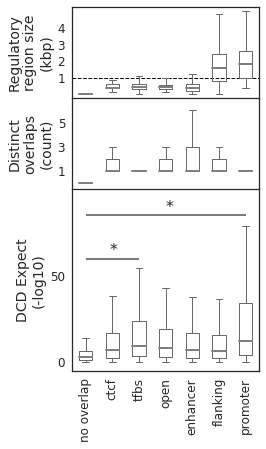

In [1]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot boxplots of HSP scores
# (not) overlapping with reg. regions

date = '20180921'

run_plot_hsp_ensreg_ovl = True

save_figures = True
diss_version = True

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

segmentations = ['cmm18', 'ecs18', 'ecs10']
scorings = ['penem', 'ordem', 'penrep', 'ordrep']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

hsp_ensreg_ovl_folder = os.path.join(fhgfs_base, 'bedtools/deep/isect_hsp_rgb')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'
    
    
def build_table_header(fpath):
    
    with open(fpath, 'r') as table:
        header = table.readline().strip('#').strip().split('\t')
    header += ['rgb_chrom', 'rgb_start', 'rgb_end',
               'rgb_name', 'rgb_score', 'rgb_strand',
               'rgb_feature', 'overlap']
    return header


def cache_ensreg_ovl_data(rootfolder, cache_file):
    
    ovl_header = None
    
    select_cols = ['name', 'expect', 'rgb_feature', 'rgb_length']
    
    for tsv in os.listdir(rootfolder):
        if not tsv.endswith('.tsv'):
            continue
        fpath = os.path.join(rootfolder, tsv)
        if ovl_header is None:
            ovl_header = build_table_header(fpath)
        # hsp_ovl_rgb_ecs10_HG_vs_Ma_penem.tsv
        _, _, _, seg, c1, _, c2, score = tsv.split('.')[0].split('_')
        comp = c1 + '_vs_' + c2

        df = pd.read_csv(fpath, sep='\t', names=ovl_header,
                         header=None, skiprows=1, low_memory=False)
        df.loc[df['overlap'] == 0, 'rgb_feature'] = 'empty'
        df['rgb_length'] = df['rgb_end'] - df['rgb_start']

        nonzero_min = df.loc[df['segment_expect'] > 0, 'segment_expect'].min()
        df.loc[df['segment_expect'] == 0, 'segment_expect'] = nonzero_min
        df['expect'] = -1 * np.log10(df['segment_expect'])
        
        df = df.loc[:, select_cols].copy()

        uniq = []
        abs_ovl = []
        for ft in df['rgb_feature'].unique():
            sub = df.loc[df['rgb_feature'] == ft, :].copy()
            ovl_counts = col.Counter(sub['name'])
            oc = col.Counter(ovl_counts.values())
            s = pd.DataFrame([oc[i] for i in sorted(oc.keys())],
                              index=[i for i in sorted(oc.keys())],
                             columns=[ft])
            s.index.name = ft
            abs_ovl.append(s)

            sub.drop_duplicates(subset=['name'], inplace=True)
            uniq.append(sub)
        
        uniq = pd.concat(uniq, axis=0, ignore_index=False, sort=False)
        abs_ovl = pd.concat(abs_ovl, axis=1, ignore_index=False, sort=False)
        abs_ovl.fillna(0, inplace=True)
        abs_ovl = abs_ovl.astype(np.int32)
                
        cache_path = os.path.join(seg, score, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(cache_path + '/segments', uniq, format='fixed')
            hdf.put(cache_path + '/overlaps', abs_ovl, format='fixed')
    return cache_path


def create_boxplot(top_values, mid_values, bottom_values, xlabels, fkey, save_diss):
    """
    """
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
                
    fig, (ax_top, ax_mid, ax_bottom) = plt.subplots(figsize=fig_sizes['one_col']['double'],
                                                    nrows=3, ncols=1, sharex=True, sharey=False,
                                                    gridspec_kw={'height_ratios': [1, 1, 2]})
    
    plt.subplots_adjust(hspace=0.005)
    
    # plot RGB feature length distribution
    bb_len = ax_top.boxplot(top_values, sym="", labels=None,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
    ax_top.axhline(y=1000, xmin=0, xmax=1, zorder=0,
                   color='black', ls='dashed', lw=1)
        
    top_max_y = 0
    for cap in bb_len['caps']:
        if max(cap.get_ydata()) > top_max_y:
            top_max_y = max(cap.get_ydata())
    if top_max_y == np.ceil(top_max_y):
        ax_top.set_ylim(-200, np.ceil(top_max_y) + 250)
    else:
        ax_top.set_ylim(-200, np.ceil(top_max_y) + 250)
    ax_top.set_ylabel('Regulatory\nregion size\n(kbp)', fontsize=14)
    if top_max_y < 1000:
        top_yticks = np.arange(0, top_max_y, step=250, dtype=np.int32)
    else:
        top_yticks = np.arange(0, top_max_y, step=1000, dtype=np.int32)
    ax_top.set_yticks(top_yticks[1:])
    ax_top.set_yticklabels(list(map(str, top_yticks // 1000))[1:], fontsize=12)
    ax_top.spines['bottom'].set_visible(False)
    if not save_diss:
        fig_title = ax_top.set_title(fkey, fontsize=16)
        fig_title.set_position((0.025, 1.01))
    
    # plot HSP RGB region overlaps
    bb_ovl = ax_mid.boxplot(mid_values, sym="", labels=None,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
#     ax_mid.axhline(y=0.9, xmin=0, xmax=1, zorder=0,
#                    color='black', ls='dashed', lw=1)
    
    mid_max_y = 0
    for cap in bb_ovl['caps']:
        if max(cap.get_ydata()) > mid_max_y:
            mid_max_y = max(cap.get_ydata())
    mid_max_y = mid_max_y + 1
    ax_mid.set_ylim(-0.5, mid_max_y)
    
    if mid_max_y < 10:
        mid_yticks = np.arange(1, mid_max_y, step=2, dtype=np.int8)
    else:
        mid_yticks = np.arange(1, mid_max_y, step=4, dtype=np.int8)
    ax_mid.set_yticks(mid_yticks)
    ax_mid.set_yticklabels(list(map(str, mid_yticks)), fontsize=12)
    ax_mid.set_ylabel('Distinct\noverlaps\n(count)', fontsize=14)
    
    ax_mid.spines['bottom'].set_visible(False)
    
    # plot HSP expects
    bb_score = ax_bottom.boxplot(bottom_values, sym="", labels=None,
                                 medianprops=median_props, boxprops=box_props,
                                 whiskerprops=whisker_props, capprops=cap_props)
    bottom_max_y = 0
    for cap in bb_score['caps']:
        if max(cap.get_ydata()) > bottom_max_y:
            bottom_max_y = max(cap.get_ydata())
    bottom_max_y = (bottom_max_y // 25) * 25 + 25
    ax_bottom.set_ylim(-5, bottom_max_y)
    
    
    if bottom_max_y < 100:
        bottom_yticks = np.arange(0, bottom_max_y, step=20, dtype=np.int16)
    else:
        bottom_yticks = np.arange(0, bottom_max_y, step=50, dtype=np.int16)
    ax_bottom.set_yticks(bottom_yticks)
    ax_bottom.set_yticklabels(list(map(str, bottom_yticks)), fontsize=12)
    ax_bottom.set_ylabel('DCD Expect\n(-log10)', fontsize=14)
    
    ax_bottom.set_xticklabels(xlabels, fontsize=12, rotation=90, ha='center')
    
    # add pv for comparisons explcicitly mentioned in the manuscript
    mwu = stats.mannwhitneyu
    
    no_ovl_group = bottom_values[0]
    
    tfbs_group = bottom_values[2]
    enh_group = bottom_values[4]
    flank_group = bottom_values[5]
    prom_group = bottom_values[6]
    
    ax_bottom.hlines([60, 85], [1., 1.], [3., 7.],
                     color='dimgrey')
    
#     pv_enh_flank = mwu(enh_group, flank_group, alternative='two-sided')[1]
#     print(pv_enh_flank)
#     assert pv_enh_flank > 0.01, '1 pv changed'
    pv_noovl_tfbs = mwu(no_ovl_group, tfbs_group, alternative='two-sided')[1]
    assert pv_noovl_tfbs < 0.01, '2 pv changed'
    pv_noovl_prom = mwu(no_ovl_group, prom_group, alternative='two-sided')[1]
    assert pv_noovl_prom< 0.01, '3 pv changed'
    
    #ax_bottom.text(4, 85, s='n.s.', fontsize=14)
    ax_bottom.text(1.9, 62, s='*', fontsize=16)
    ax_bottom.text(4, 87, s='*', fontsize=16)
    
    return fig, []


def make_ovl_array(counts):
    concats = []
    for elem, rep in counts.items():
        concats.append(np.repeat([elem], rep))
    concats = np.concatenate(concats)
    return concats


def plot_hsp_ensreg_ovl():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp-ovl-rgb.h5'.format(date))
    if not os.path.isfile(cache_file):
        _ = cache_ensreg_ovl_data(hsp_ensreg_ovl_folder, cache_file)
    elif os.stat(cache_file).st_size < 10e6:
        _ = cache_ensreg_ovl_data(hsp_ensreg_ovl_folder, cache_file)
    else:
        print('Assuming cache file is valid')

    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        x_labels = ['no overlap', 'ctcf', 'tfbs', 'open', 'enhancer', 'flanking', 'promoter']
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for score in scorings:
                if score != 'penem':
                    continue
                load_keys = [k for k in cached_keys if seg in k and score in k]

                collect_exp = col.defaultdict(list)
                collect_len = col.defaultdict(list)
                
                collect_ovl = col.defaultdict(list)
                
                rgb_feat = ['empty', 'ctcf', 'tfbs', 'open', 'enhancer', 'flanking', 'promoter']
                for k in load_keys:
                    data = hdf[k]
                    if k.endswith('/segments'):
                        for x in rgb_feat:
                            collect_exp[x].append(data.loc[data['rgb_feature'] == x, 'expect'].values)
                            if x != 'empty':
                                collect_len[x].append(data.loc[data['rgb_feature'] == x, 'rgb_length'].values)
                    else:
                        # skip over empty
                        for x in rgb_feat[1:]:
                            collect_ovl[x].append(make_ovl_array(data[x]))

                expect = [np.concatenate(collect_exp[x]) for x in rgb_feat]
                overlaps = [np.concatenate(collect_ovl[x]) for x in rgb_feat[1:]]
                overlaps = [np.array([0])] + overlaps
                lengths = [np.concatenate(collect_len[x]) for x in rgb_feat[1:]]
                lengths = [np.array([0])] + lengths
                
                fk = '5'
                fig, exart = create_boxplot(lengths, overlaps, expect, x_labels, fk, diss_version)

                if save_figures:
                    outname = 'fig_{}_hsp-regbuild_{}_{}'.format(fk, seg, score)
                    if diss_version:
                        outfolder = fig_diss
                    else:
                        outfolder = fig_main
                    
                    out_pdf = os.path.join(outfolder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(outfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0

    
if run_plot_hsp_ensreg_ovl:
    plot_hsp_ensreg_ovl()
